# Imports

In [1]:
# === Standard Library ===
import os
import glob
import json
from pathlib import Path
import random

# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Scikit-learn: Preprocessing ===
from sklearn.preprocessing import OneHotEncoder

# === Scikit-learn: Model Selection ===
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# === Scikit-learn: Models ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD

# === XGBoost ===
from xgboost import XGBClassifier

# === Scikit-learn: Evaluation ===
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, accuracy_score, roc_curve, auc as sk_auc
from sklearn.utils.class_weight import compute_class_weight

# === Persistence ===
from joblib import dump, load

# === Imbalanced-learn ===
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

2025-06-09 14:40:45.113155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Settings
Specify the paths for input data (TF-IDF matrices) and model saving. Define the quarters to be used for training and labeling.

In [2]:
tfidf_path = Path(f"../words_TFIDF/")
conventional_model_save_path = Path(f"./conventional_models/")
nn_model_save_path = Path(f"./NN_models/")

quarters = [
    "Q1-2023",
    "Q2-2023",
    "Q3-2023",
    "Q4-2023",
    "Q1-2024",
    "Q2-2024",
    "Q3-2024",
    "Q4-2024"
]


# Load TF-IDF for Q1 2025
tfidf_df_q12025 = pd.read_csv(f"{tfidf_path}/tfidf_q1_2025.csv")
# Load TF-IDF for Q1 2023 - Q4 2024
tfidf_df_otherq = pd.read_csv(f"{tfidf_path}/tfidf_non_q1_2025.csv")

# Load Data
Read the TF-IDF matrices from CSV files: one for the latest test quarter (Q1 2025) and one for historical quarters (Q1 2023–Q4 2024).

Also, function to recursively load EPS CSVs from each company’s folder. Store each company's EPS data in a dictionary for quick lookup by name.

In [3]:
# Recursively find all EPS CSVs under data/
eps_files = glob.glob("../../data/**/EPS-*.csv", recursive=True)

# Build company-to-DataFrame map (case-insensitive)
eps_data = {}

for filepath in eps_files:
    # Use parent folder name as company name
    company_name = os.path.basename(os.path.dirname(filepath))
    try:
        df = pd.read_csv(filepath)
        df['Quarter'] = df['Quarter'].str.strip().str.upper()
        df['Company'] = company_name
        eps_data[company_name.lower()] = df  # Store using lowercase key
    except Exception as e:
        print(f"Error loading {filepath}: {e}")

# === Load TF-IDF Data ===
tfidf_train = pd.read_csv(f"{tfidf_path}/tfidf_non_q1_2025.csv")  # Q1 2023 to Q4 2024    
tfidf_test = pd.read_csv(f"{tfidf_path}/tfidf_q1_2025.csv")       # Q1 2025

# Preprocess Train and Test Data

Merge EPS data with the current TFIDF data and label.
1. Label = 1  if  EPS in current_quarter > EPS in past_quarter
2. Label = 0  otherwise (EPS decreased or stayed the same)

In [4]:
# === Function to get EPS label (EPS increase between two quarters) ===
def get_eps_label(company_name, past_quarter, current_quarter):
    key = company_name.lower()
    if key not in eps_data:
        return None
    df = eps_data[key]
    try:
        eps_before = df.loc[df['Quarter'] == past_quarter.upper(), 'EPS'].values[0]
        eps_current = df.loc[df['Quarter'] == current_quarter.upper(), 'EPS'].values[0]
        return int(eps_current > eps_before)
    except IndexError:
        return None
  
### ============ TRAIN DATA ============ ##
quarters_dash = [
    "Q1-2023",
    "Q2-2023",
    "Q3-2023",
    "Q4-2023",
    "Q1-2024",
    "Q2-2024",
    "Q3-2024",
    "Q4-2024"
]

quarters_eps = [q.replace("-", "") for q in quarters_dash] # Convert to EPS-style format "Q12023, Q22023, Q32023, Q42023"
all_train_dfs = [] # Collect all labeled training rows

for idx in range(len(quarters_dash)):
    current_q_dash = quarters_dash[idx]
    current_q_eps = quarters_eps[idx]
    
    if idx == 0:
        past_q_eps = "Q42022"
    else:
        past_q_eps = quarters_eps[idx - 1]

    # Filter TF-IDF for current quarter
    df_train_q = tfidf_train[tfidf_train["quarter"] == current_q_dash].copy()
    
    # Label with EPS increase between past and current quarter
    df_train_q["Label"] = df_train_q["company"].apply(lambda c: get_eps_label(c, past_q_eps, current_q_eps))
    df_train_q = df_train_q.dropna(subset=["Label"])

    all_train_dfs.append(df_train_q)

# Final training data
train_df_combined = pd.concat(all_train_dfs, ignore_index=True)

### ============ TEST DATA ============ ##
df_test_q = tfidf_test.copy()

df_test_q["Label"] = df_test_q["company"].apply(lambda c: get_eps_label(c, "Q42024", "Q12025"))
df_test_q = df_test_q.dropna(subset=["Label"])

# Feature Reduction and Sector Encoding
1. Drop metadata columns (`company`, `quarter`).
2. Apply Truncated SVD to reduce dimensionality of TF-IDF features for computational efficiency.
3. One-hot encode the `Sector` column to include categorical context.
4. Concatenate the reduced TF-IDF matrix and sector encoding for model training input.

In [5]:
# 1. Drop company and quarter
df_train = train_df_combined.drop(columns=["company", "quarter"])
df_test = df_test_q.drop(columns=["company", "quarter"])

# 2. Separate features and target
X_train_tfidf = df_train.drop(columns=["Sector", "Label"])  # TF-IDF (1000 cols)
y_train = df_train["Label"].astype(int)

X_test_tfidf = df_test.drop(columns=["Sector", "Label"])
y_test = df_test["Label"].astype(int)

# 3. Reduce dimensionality of TF-IDF
svd = TruncatedSVD(n_components=10, random_state=42)
X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)

X_test_tfidf_reduced = svd.transform(X_test_tfidf)  # Use same svd from training

# 4. One-hot encode sector
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sector_train_encoded = encoder.fit_transform(df_train[["Sector"]])  # must be 2D
sector_test_encoded = encoder.transform(df_test[["Sector"]])  # Use same encoder from training

# 5. Concatenate reduced TF-IDF + Sector features
X_train = np.hstack([X_train_tfidf_reduced, sector_train_encoded])
X_test = np.hstack([X_test_tfidf_reduced, sector_test_encoded])

# Model Training with GridSearchCV
We will try to answer: "Will EPS increase in Q1 2025 compared to Q4 2024?"

- Features: All TFIDF words
- Target: Binary (0 = no increase, 1 = increase)

Define pipelines for multiple classifiers (Logistic Regression, Random Forest, XGBoost, KNN, SVM with RBF) using SMOTE for oversampling. 

Perform hyperparameter tuning using GridSearchCV with 5-fold stratified cross-validation, optimizing for F1-score. 

Save the best model from each classifier.

In [6]:
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(class_weight="balanced", max_iter=1000),
        "params": {
            "model__C": [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42),
        "params": {
            "model__n_estimators": [100, 200, 300],
            "model__max_depth": [None, 10, 20, 30],
            "model__min_samples_split": [2, 5],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [3, 6, 9],
            "model__learning_rate": [0.01, 0.1],
            "model__scale_pos_weight": [1, 2]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": [3, 5, 7],
            "model__weights": ["uniform", "distance"],
            "model__metric": ["euclidean", "manhattan"]
        }
    },
    "SVM (RBF)": {
        "model": SVC(class_weight="balanced", probability=True),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__gamma": ["scale", 0.01, 0.001],
            "model__kernel": ["rbf"]
        }
    }
}

# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run GridSearch for each classifier
best_models = []
for name, spec in param_grids.items():
    print(f"\n=== GridSearchCV for {name} ===")

    # Create pipeline with SMOTE and model
    pipeline = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("model", spec["model"])
    ])

    grid = GridSearchCV(pipeline, spec["params"], cv=skf, scoring="f1", n_jobs=2)
    grid.fit(X_train, y_train)
    
    print(f"Best params: {grid.best_params_}")
    print(f"Best CV F1: {grid.best_score_:.4f}")
    
    best_model = grid.best_estimator_
    best_models.append((name, best_model))

    dump(best_model, f"{conventional_model_save_path}/best_model_{name.replace(' ', '_')}_10_components.joblib")
    print(f"Model saved: best_model_{name.replace(' ', '_')}_10_components.joblib")


=== GridSearchCV for Logistic Regression ===
Best params: {'model__C': 10}
Best CV F1: 0.5404
Model saved: best_model_Logistic_Regression_10_components.joblib

=== GridSearchCV for Random Forest ===
Best params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best CV F1: 0.5515
Model saved: best_model_Random_Forest_10_components.joblib

=== GridSearchCV for XGBoost ===
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__scale_pos_weight': 2}
Best CV F1: 0.7366
Model saved: best_model_XGBoost_10_components.joblib

=== GridSearchCV for KNN ===
Best params: {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'model__weights': 'distance'}
Best CV F1: 0.5530
Model saved: best_model_KNN_10_components.joblib

=== GridSearchCV for SVM (RBF) ===
Best params: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best CV F1: 0.5238
Model saved: best_model_SVM_(RB

# Load Trained Models
Load the best models for each classifier from disk.
If any model is missing, print a warning. This allows evaluation without re-training.

In [7]:
model_names = ["Logistic_Regression", "Random_Forest", "XGBoost", "KNN", "SVM_(RBF)"]
best_models_loaded = []

for name in model_names:
    model_path = f"{conventional_model_save_path}/best_model_{name}_10_components.joblib"
    if os.path.exists(model_path):
        model = load(model_path)
        best_models_loaded.append((name.replace("_", " "), model))
    else:
        print(f"[Warning] Model file not found: {model_path}")

# Evaluate Models on Q1 2025 Test Set
Evaluate each conventional model on the test data:
- Compute accuracy, F1 score, AUC-ROC.
- Handle classifiers with or without `predict_proba`.
- Save all detailed results (including classification reports and confusion matrices) into a JSON file for future reference or analysis.

In [8]:
detailed_results = []

for name, model in best_models_loaded:
    print(f"\n=== {name} Evaluation on Q1 2025 Test Set ===")
    y_pred = model.predict(X_test)

    # Get predicted probabilities or scores for AUC-ROC
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_prob = model.decision_function(X_test)
    except Exception as e:
        print(f"Could not compute AUC-ROC for {name}: {e}")
        y_prob = None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else float("nan")

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    class_report = classification_report(y_test, y_pred, digits=4, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    detailed_results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "AUC-ROC": auc,
        "Classification Report": class_report,
        "Confusion Matrix": conf_matrix.tolist()  # Convert numpy array to list
    })

# Save the full detailed results as JSON
with open(f"{conventional_model_save_path}/q1_2025_detailed_results_10_components.json", "w") as f:
    json.dump(detailed_results, f, indent=4)

print("Detailed results saved to 'q1_2025_detailed_results_10_components.json'")


=== Logistic Regression Evaluation on Q1 2025 Test Set ===
Accuracy: 0.5294
F1 Score: 0.5556
AUC-ROC: 0.5729

=== Random Forest Evaluation on Q1 2025 Test Set ===
Accuracy: 0.5000
F1 Score: 0.5143
AUC-ROC: 0.4566

=== XGBoost Evaluation on Q1 2025 Test Set ===
Accuracy: 0.5294
F1 Score: 0.6923
AUC-ROC: 0.4774

=== KNN Evaluation on Q1 2025 Test Set ===
Accuracy: 0.5588
F1 Score: 0.5455
AUC-ROC: 0.4323

=== SVM (RBF) Evaluation on Q1 2025 Test Set ===
Accuracy: 0.5294
F1 Score: 0.5000
AUC-ROC: 0.5347
Detailed results saved to 'q1_2025_detailed_results_10_components.json'


/Users/christopheryang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christopheryang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christopheryang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

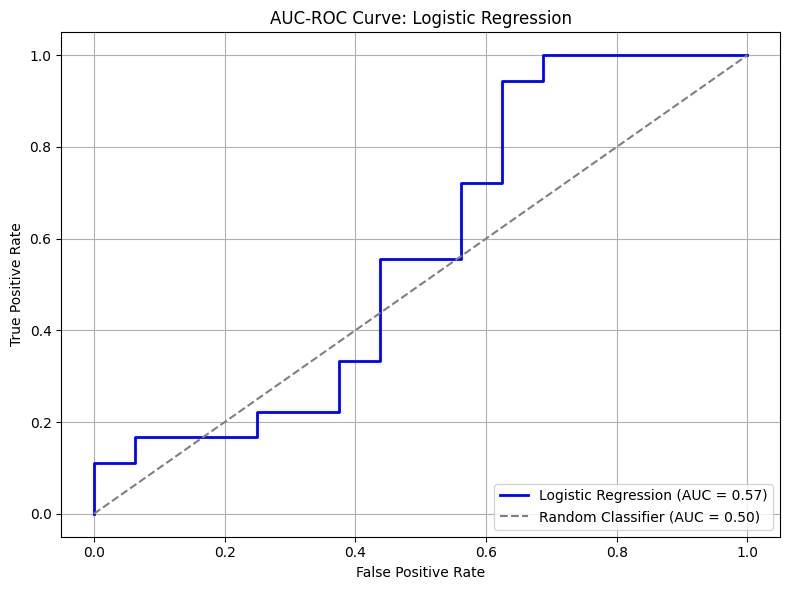

In [9]:
# Extract the logistic regression model directly
log_reg_model = next(model for name, model in best_models_loaded if "logistic" in name.lower())

# Predict probabilities for the positive class
y_scores = log_reg_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = sk_auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve: Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
detailed_results = pd.DataFrame(detailed_results).sort_values("F1 Score", ascending=False)
detailed_results

,Model,Accuracy,F1 Score,AUC-ROC,Classification Report,Confusion Matrix
2,XGBoost,0.529412,0.692308,0.477431,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc...","[[0, 16], [0, 18]]"
0,Logistic Regression,0.529412,0.555556,0.572917,"{'0': {'precision': 0.5, 'recall': 0.5, 'f1-sc...","[[8, 8], [8, 10]]"
3,KNN,0.558824,0.545455,0.432292,"{'0': {'precision': 0.5263157894736842, 'recal...","[[10, 6], [9, 9]]"
1,Random Forest,0.500000,0.514286,0.456597,"{'0': {'precision': 0.47058823529411764, 'reca...","[[8, 8], [9, 9]]"
4,SVM (RBF),0.529412,0.500000,0.534722,"{'0': {'precision': 0.5, 'recall': 0.625, 'f1-...","[[10, 6], [10, 8]]"


# Deep Learning Model Training and Evaluation
Build, train, and evaluate a Keras-based neural network:
- Dense layers with ReLU, batch normalization, dropout, and L2 regularization.
- Use class weights to handle label imbalance.
- Plot and save accuracy/loss curves.
- Evaluate using AUC-ROC and a confusion matrix.
- Save trained model (`.h5`) and confusion matrix plot to `./NN_models/`.

Epoch 1/100
12/12 [==============================] - 2s 27ms/step - loss: 1.0434 - accuracy: 0.4740 - val_loss: 0.7035 - val_accuracy: 0.6145
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.9728 - accuracy: 0.4896 - val_loss: 0.7027 - val_accuracy: 0.6024
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.9069 - accuracy: 0.5469 - val_loss: 0.7021 - val_accuracy: 0.6506
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 0.8844 - accuracy: 0.5104 - val_loss: 0.7010 - val_accuracy: 0.6145
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 0.9567 - accuracy: 0.5417 - val_loss: 0.6997 - val_accuracy: 0.5783
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.8528 - accuracy: 0.5781 - val_loss: 0.6993 - val_accuracy: 0.5783
Epoch 7/100
12/12 [==============================] - 0s 5ms/step - loss: 0.9592 - accuracy: 0.4896 - val_loss: 0.6988 - val_accuracy: 0.5783
Epoch 8/100


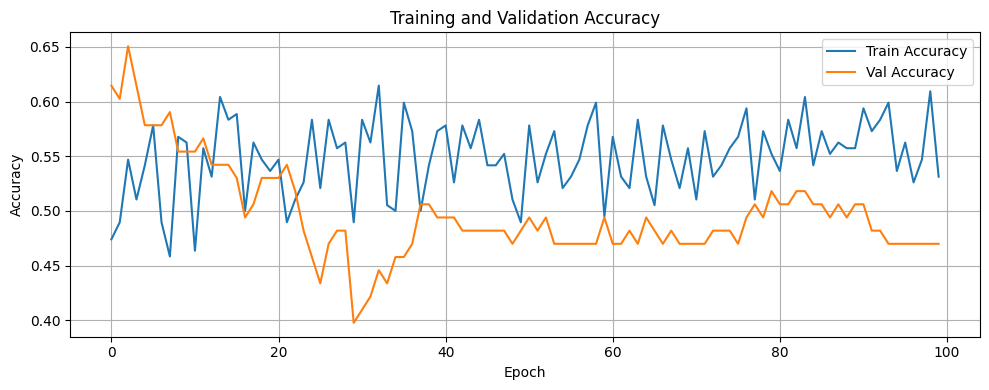

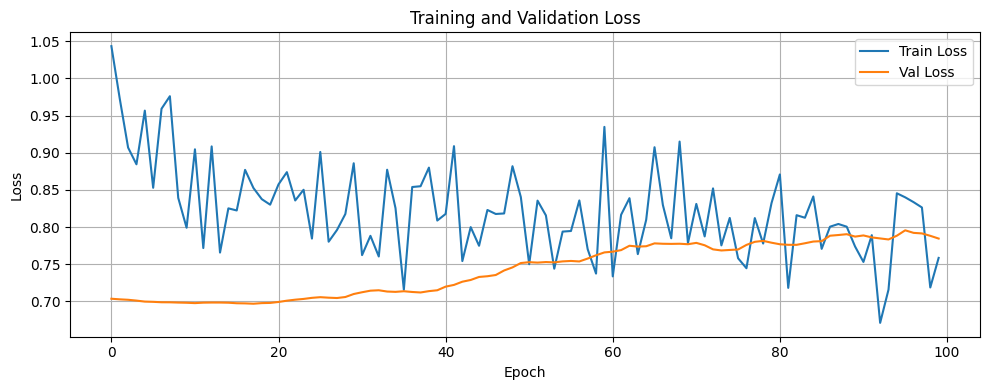

2/2 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        16
           1       0.75      0.67      0.71        18

    accuracy                           0.71        34
   macro avg       0.71      0.71      0.71        34
weighted avg       0.71      0.71      0.71        34

AUC-ROC: 0.75


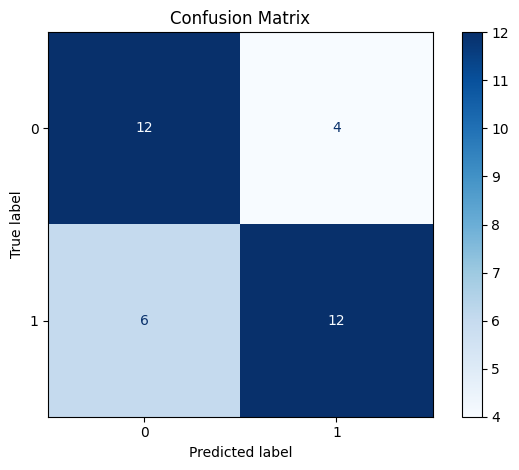

/Users/christopheryang/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# === Data Preparation ===
X_train_nn = X_train if isinstance(X_train, np.ndarray) else X_train.toarray()
X_test_nn = X_test if isinstance(X_test, np.ndarray) else X_test.toarray()

# === Class Weight Computation ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# === Model Definition ===
model = Sequential([
    Input(shape=(X_train_nn.shape[1],)),
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

# === Model Compilation ===
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === Model Training ===
history = model.fit(
    X_train_nn, y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=16,
    class_weight=class_weight_dict,
    verbose=1
)

# === Plot Accuracy ===
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{nn_model_save_path}/accuracy_plot_10_components.png")
plt.show()

# === Plot Loss ===
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{nn_model_save_path}/loss_plot_10_components.png")
plt.show()

# === Model Evaluation ===
y_pred_prob = model.predict(X_test_nn)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))

# === Save Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{nn_model_save_path}/confusion_matrix_10_components.png")
plt.show()

# === Save Model ===
model.save(f"{nn_model_save_path}/nn_model_10_components.h5")


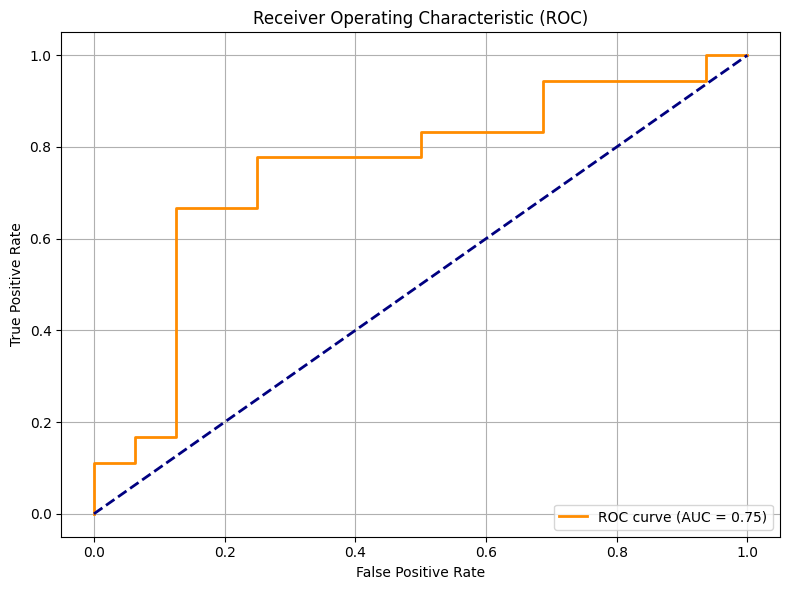

In [12]:
# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_value = sk_auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{nn_model_save_path}/roc_curve_10_components.png")
plt.show()